Dataset shape: (5572, 2)
Spam percentage: 13.41%
Model input dimension: 1000


/home/nicholas/Desktop/ML projects/spam-detector-ml/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:865: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch    0 | Loss: 0.7087
Epoch   10 | Loss: 0.5635
Epoch   20 | Loss: 0.2680
Epoch   30 | Loss: 0.1554
Epoch   40 | Loss: 0.1092

Test Loss: 0.1044
Test Accuracy: 99.10%


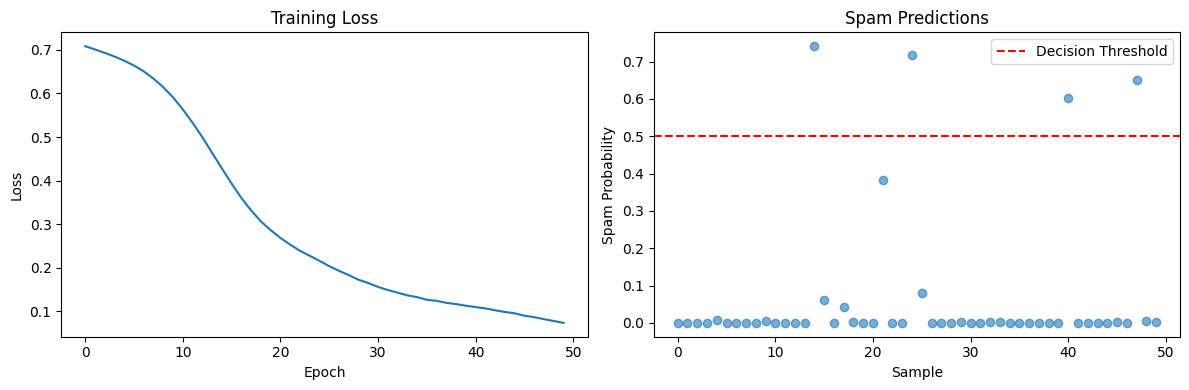

Text: Win a free iPhone now! Call 123-456-7890...
  Probability: 0.5570 | Prediction: SPAM

Text: Hey, are we meeting tomorrow for lunch?...
  Probability: 0.0000 | Prediction: HAM

Text: Congratulations! You've won $1,000,000! Click here...
  Probability: 0.5665 | Prediction: SPAM



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Load data
data_path = "./data/SMSSpamCollection.csv"
df = pd.read_csv(
    data_path,
    sep="\t",
    header=None,
    names=["label", "text"]
)

# Convert labels to numeric
df['label'] = df["label"].map({"ham": 0, "spam": 1})

print(f"Dataset shape: {df.shape}")
print(f"Spam percentage: {(df['label'].sum() / len(df) * 100):.2f}%")

# ========== CRITICAL: CONVERT TEXT TO NUMBERS ==========
# You CANNOT use text directly in PyTorch models
# Convert text to numerical features
vectorizer = CountVectorizer(max_features=1000)  # Keep top 1000 words
X_numerical = vectorizer.fit_transform(df['text']).toarray()

# Now convert to PyTorch tensors
X_tensor = torch.tensor(X_numerical, dtype=torch.float32)
y_tensor = torch.tensor(df['label'].values, dtype=torch.float32).unsqueeze(1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42, shuffle=True
)

# ========== FIXED MODEL ==========
# Input features should match vectorized text dimension (1000)
class SpamDetectModel(nn.Module):
    def __init__(self, input_dim=1000):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1),
            nn.Sigmoid()  # For binary classification
        )
    
    def forward(self, x):
        return self.network(x)

# ========== FIXED TRAINING ==========
model = SpamDetectModel(input_dim=X_train.shape[1])
print(f"Model input dimension: {X_train.shape[1]}")

# Use BCE loss for binary classification (not MSE)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50
losses = []

def train():
    for epoch in range(epochs):
        model.train()
        predictions = model(X_train)
        loss = loss_fn(predictions, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch:4d} | Loss: {loss.item():.4f}")
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test)
        test_loss = loss_fn(test_predictions, y_test)
        # Convert probabilities to binary predictions
        binary_preds = (test_predictions > 0.5).float()
        accuracy = (binary_preds == y_test).float().mean()
        
        print(f"\nTest Loss: {test_loss.item():.4f}")
        print(f"Test Accuracy: {accuracy.item()*100:.2f}%")
    
    return test_predictions

def sketch():
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    
    plt.subplot(1, 2, 2)
    model.eval()
    with torch.no_grad():
        sample_preds = model(X_test[:50])
    plt.scatter(range(50), sample_preds.numpy(), alpha=0.6)
    plt.xlabel("Sample")
    plt.ylabel("Spam Probability")
    plt.title("Spam Predictions")
    plt.axhline(y=0.5, color='r', linestyle='--', label='Decision Threshold')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Run
predictions = train()
sketch()

# ========== TEST WITH NEW TEXT ==========
def predict_new_text(texts):
    """Predict if new texts are spam"""
    # MUST convert new text the SAME way as training text
    new_text_vectorized = vectorizer.transform(texts).toarray()
    new_tensor = torch.tensor(new_text_vectorized, dtype=torch.float32)
    
    model.eval()
    with torch.no_grad():
        probabilities = model(new_tensor)
        predictions = (probabilities > 0.5).int()
    
    for text, prob, pred in zip(texts, probabilities, predictions):
        label = "SPAM" if pred.item() == 1 else "HAM"
        print(f"Text: {text[:50]}...")
        print(f"  Probability: {prob.item():.4f} | Prediction: {label}")
        print()

# Test with some examples
test_texts = [
    "Win a free iPhone now! Call 123-456-7890",
    "Hey, are we meeting tomorrow for lunch?",
    "Congratulations! You've won $1,000,000! Click here"
]

predict_new_text(test_texts)